# Section F. Logistic Regression vs. Bayesian Classifier
## Question 7 [Discriminative vs Generative Models]

In [1]:
#install.packages("mvtnorm")
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2)

Warning message:
“package ‘mvtnorm’ was built under R version 3.5.2”Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”

### I
Loading the train and test data

In [2]:
set.seed(1234)
train = read.csv("assignment1_datasets/Task1E_train.csv")
test = read.csv("assignment1_datasets/Task1E_test.csv")
# suffle the dataset
ind = sample(1:nrow(train),nrow(train))
train = train[ind,]

ind = sample(1:nrow(test),nrow(test))
test = test[ind,]

train_features = as.matrix(train[,-ncol(train)])
train_features = scale(train_features)
train_target = as.matrix(train[,ncol(train)])
test_features = as.matrix(test[,-ncol(test)])
test_features = scale(test_features)
test_target = as.matrix(test[,ncol(test)])


c0 <- +1
c1 <- -1

### II 
Bayesian Classifier 

In [3]:
errors = data.frame("Train Size"=c(1:(nrow(train)/5)),"Train Error"=0,"Test Error"=0)

indx = 1
for (i in seq(0,nrow(test),5)[-1]){
    
    train_x = as.matrix(train_features[1:i,])
    train_y = as.matrix(train_target[1:i])
    
    #calculate the prior for each class
    prior_0 = sum(train_y == c0)/ length(train_y)
    prior_1 = sum(train_y == c1)/ length(train_y)
    
    features_0 = matrix(train_x[train_y == c0,],ncol=2)
    features_1 = matrix(train_x[train_y == c1,],ncol = 2)
    
    #estimate population mean for each class
    mu_0 = colMeans(features_0)
    mu_1 = colMeans(features_1)

    # for small dataset, there may be chances that the sample may not have any occurence of other class
    if(nrow(features_0) < 2){
        var_0 = matrix(0,nrow=2,ncol=2)  
    }else{
        var_0 = var(features_0)
    }
    
    if(nrow(features_1) < 2){
        var_1 = matrix(0,nrow=2,ncol=2)   
    }else{
        var_1 = var(features_1)
    }
    
    sigma = (prior_0 * var_0) + (prior_1 * var_1)
    
    # estimating posterior probabilities for training set
    posterior_0_train = prior_0 * dmvnorm(x=train_x, mean=mu_0, sigma=sigma)
    posterior_1_train = prior_1 * dmvnorm(x=train_x, mean=mu_1, sigma=sigma)
 
    
    # predicing classes for training set
    train_prediction = ifelse(posterior_0_train > posterior_1_train, c0, c1)
    train_error = (sum(train_prediction != train_y)/nrow(train_x))*100

    # estimating posterior probabilities for test set
    posterior_0_test = prior_0 * dmvnorm(x=test_features, mean=mu_0, sigma=sigma)
    posterior_1_test = prior_1 * dmvnorm(x=test_features, mean=mu_1, sigma=sigma)
  
    # predicing classes for test set
    test_prediction = ifelse(posterior_0_test > posterior_1_test, c0, c1)
    test_error = (sum(test_prediction != test_target)/nrow(test_features) ) *100

    
    errors[indx,"Train.Size"] = i
    errors[indx,"Train.Error"] = train_error
    errors[indx,"Test.Error"] = test_error
    indx =indx+1


    
    
    
    }
print(table(test_target, test_prediction))

           test_prediction
test_target  -1   1
         -1 151   7
         1    0 342


Stochastic Gradient Decent to find the sub-optimal theta value

In [4]:
sgd <- function (x,y,eta,epsilon,max_epoch = 20) {
    m = dim(x)[1]
    n = dim(x)[2]

  
    cnt = 1
    max_count = max_epoch * m
    theta = as.matrix(runif(n))
    
    #cost_rec = matrix(Inf)
    #theta_rec = as.matrix(t(theta))
    
    
    while(cnt < max_count){
        x_index = sample(1:m, m, replace = FALSE)
        
        for (i in x_index){
            
            hypothesis = x[i,] %*% theta
            prob = sigmoid(hypothesis)
            cost = -((y[i] * log(prob)) + ((1-y[i]) * log(1-prob)))/m
    
            grad = t((prob - y[i]) %*% x[i,])
            theta = theta - (eta*grad)
            cnt = cnt+1            
            if(cnt > max_count){
                break
            }
        }
        
        
    }
    
    return (matrix(theta,ncol=1))
}



Logistic Regression

In [5]:
sigmoid <- function(z){
    return(1.0/(1.0+exp(-z))) 
}

In [6]:
logistic_regression <- function(train_x,train_y,test_x,test_y,eta=0.01,max_epoch=10){

    train_x = cbind(1,train_x)
    test_x = cbind(1,test_x)
    
    
    # changing labels to 0 and 1 for convenience 
    train_y = ifelse(train_y == -1,0,1)
    test_y = ifelse(test_y == -1,0,1)
    
    # Getting the optimal theta value
    theta = sgd(train_x,train_y,eta,max_epoch)
    
    # formulating the hypothesis
    hypothesis = test_x %*% theta
    prob = sigmoid(hypothesis)
    
    # predicting classes based on probabilities
    prediction = ifelse(prob >= 0.5 ,1,0)
    
    # calculating the test error
    error = (sum(prediction != test_y)/nrow(test_x) ) *100

    return(error)
    
    
    
}

Calculating error for logistic regression for different training sizes

In [7]:
indx = 1
errors["LR"] = 0
for (i in seq(0,nrow(test),5)[-1]){
    
    errors[indx,"LR"] = logistic_regression(train_features[1:i,],train_target[1:i],test_features,test_target,eta=0.01,max_epoch=20)
    indx = indx+1
}

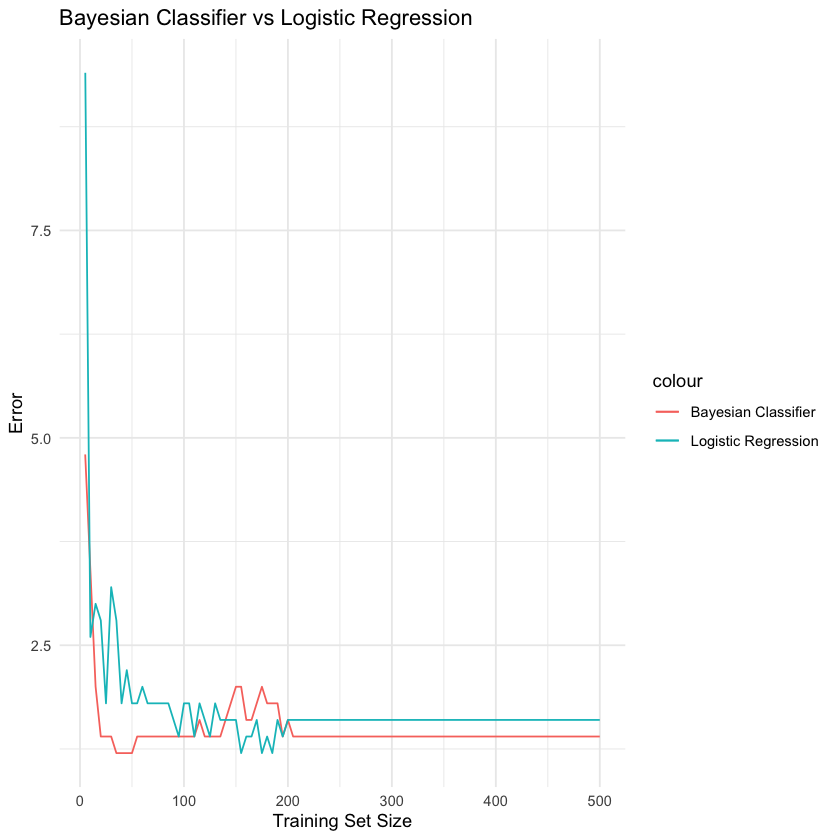

In [8]:
ggplot(data=errors,aes(x = Train.Size))+geom_line(aes(y = Test.Error,color = "Bayesian Classifier")) +
    geom_line(aes(y = LR,color = "Logistic Regression"))+ ggtitle('Bayesian Classifier vs Logistic Regression') +
    theme_minimal() + ylab("Error") + xlab("Training Set Size")


Plotting the error with respect to training size

### III

#### a

From the graph above we can observe that as the size of training data increases the test error decreses for both the models, which is apparently due to more information now the model has to learn, thereby the prediction gets more and more accurate

#### b 

From small sample size, both the classifiers perform almost equally with time to time one giving a slighty better result than other but as the size of the training data increases the bayesian classifier tends to outperforms logistic regression classifier.

#### c

- For the over all trend of the graph, as discussed earlier,as the size of training data increases the test error decreses for both the models, which is apparently due to more information now the model has to learn, thereby the prediction gets more and more accurate. 

- Secondly as the training size is small, both the classifiers perform equal because there is not much data to learn from. Also, if the data set is small, there are chances that logistic regression may outperform the bayesian classifier as the distribution of the original population may not be duplicated in the training sample, which may lead to a wrong estimate of mean and variance of the original population thereby making the classifier perform really bad. But as the size of the training set increases, the sample would start replicating the original population thereby giving a better estimate of mean and variance. This would inturn lead to a better model as it  takes into account the distribution of data in the population.
